In [1]:
%load_ext autoreload
%autoreload 2

from src.models.gps import GPS
from src.models.gcn import GCN
from src.models.explainer.explainer_pipeline import ExplainerPipeline
from src.models.explainer.gnn_explainer import GNNExplainer
from src.data import loader

import networkx as nx

from torch_geometric.explain import ModelConfig

The node_mask and edge_mask attributes filter out nodes and edges belonging to motifs.

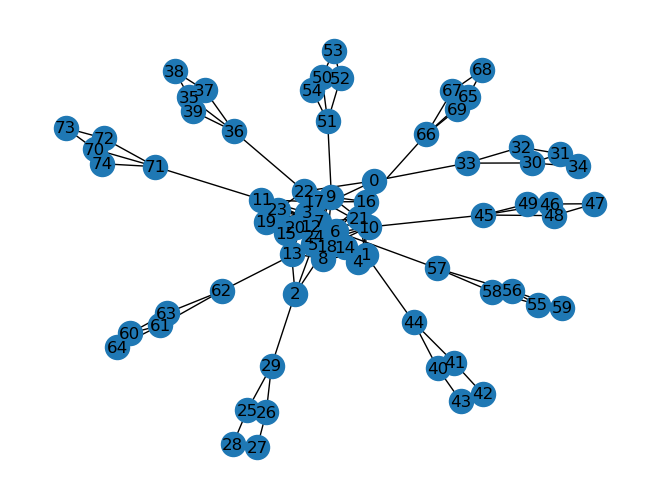

In [2]:
data, num_classes, data_networkx = loader.load_clean_bashapes(num_nodes=25, num_edges=5, num_motifs=10, laplacian_eigenvector_dimensions=2)
nx.draw(data_networkx, with_labels=True)

In [3]:
gps_params = {
    'pe_channels': 2,
    'num_layers': 4,
    'hidden_channels': 4,
    'num_attention_heads': 1,
    'observe_attention': True
}

gcn_params = {
    "hidden_channels": 20,
    "num_layers": 3
}

explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    )
}

explainer_pipeline = ExplainerPipeline(data, num_classes, GCN, GNNExplainer, model_params=gcn_params, explainer_params=explainer_params, epochs=4000)
explainer_pipeline.get_accuracies()

100%|██████████| 4000/4000 [00:31<00:00, 125.02it/s]


Train accuracy: 0.7
Test accuracy: 0.6


In [4]:
explainer_pipeline.explain(26, laplacian_eigenvector_pe=explainer_pipeline.data.laplacian_eigenvector_pe)

100%|██████████| 100/100 [00:01<00:00, 67.01it/s]


In [5]:
explanation = explainer_pipeline.explanations[26]
explanation

Explanation(node_mask=[75, 1], edge_mask=[298], prediction=[75, 4], target=[75], index=[1], x=[75, 1], edge_index=[2, 298], laplacian_eigenvector_pe=[75, 2])

In [6]:
explanation.edge_mask

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

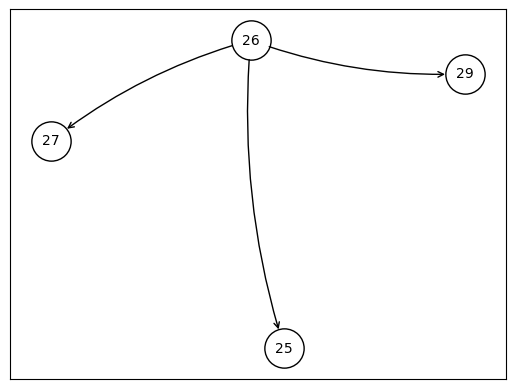

In [7]:
explanation.visualize_graph()

In [8]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch_geometric.transforms as T
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCN
from torch_geometric.utils import k_hop_subgraph

data

idx = torch.arange(data.num_nodes)
train_idx, test_idx = train_test_split(idx, train_size=0.8, stratify=data.y)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCN(data.num_node_features, hidden_channels=20, num_layers=3,
            out_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=-1)

    train_correct = int((pred[train_idx] == data.y[train_idx]).sum())
    train_acc = train_correct / train_idx.size(0)

    test_correct = int((pred[test_idx] == data.y[test_idx]).sum())
    test_acc = test_correct / test_idx.size(0)

    return train_acc, test_acc


pbar = tqdm(range(1, 2001))
for epoch in pbar:
    loss = train()
    if epoch == 1 or epoch % 200 == 0:
        train_acc, test_acc = test()
        pbar.set_description(f'Loss: {loss:.4f}, Train: {train_acc:.4f}, '
                             f'Test: {test_acc:.4f}')
pbar.close()
model.eval()

for explanation_type in ['phenomenon', 'model']:
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=300),
        explanation_type=explanation_type,
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='raw',
        ),
    )

    # Explanation ROC AUC over all test nodes:
    targets, preds = [], []
    node_indices = range(400, data.num_nodes, 5)
    for node_index in tqdm(node_indices, leave=False, desc='Train Explainer'):
        target = data.y if explanation_type == 'phenomenon' else None
        explanation = explainer(data.x, data.edge_index, index=node_index,
                                target=target)

        _, _, _, hard_edge_mask = k_hop_subgraph(node_index, num_hops=3,
                                                 edge_index=data.edge_index)

        targets.append(data.edge_mask[hard_edge_mask].cpu())
        preds.append(explanation.edge_mask[hard_edge_mask].cpu())

    auc = roc_auc_score(torch.cat(targets), torch.cat(preds))
    print(f'Mean ROC AUC (explanation type {explanation_type:10}): {auc:.4f}')

Loss: 0.6787, Train: 0.7833, Test: 0.8000: 100%|██████████| 2000/2000 [00:06<00:00, 317.56it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [24]:
import src.data.loader as loader
import src.models.gps as gps
import torch_geometric.data

#basic test on cora for dev purposes
cora_data, num_classes = loader.load_clean_cora()
model = gps.GPS(cora_data, num_classes, pe_channels=5, hidden_channels=2, observe_attention=True)
w = gps.train(model, cora_data) # w is a list of N attention matrices where N = # of transformer layers
single_matrix = w[0][0]
train_acc, test_acc = gps.test(model, cora_data)
print(f'Train Accuracy for Cora node-level classification: {train_acc}')
print(f'Test Accuracy for Cora node-level classification: {test_acc}')

  0%|          | 0/100 [00:00<?, ?it/s]


UnboundLocalError: local variable 'layer_weights' referenced before assignment

In [68]:
def max_reduce(matrix):

    #apply max reduction along columns (dim = 1)
    max_values, _ = matrix.max(dim=1)
    return max_values

In [69]:
#finds the weighted_average for one singular attention matrix

#when summing across dim=0, output shows how much attention each node receives, when dim=1, it shows how much attention each node is giving

def weighted_average_received(attention_matrix):
    
    # Apply softmax across rows (dim=1) to normalize each row of the attention matrix
    softmax_attention = F.softmax(attention_matrix, dim=1)
    
    # Compute the weighted average across each row (dim=1) by summing
    weighted_avg = softmax_attention.sum(dim=0)  # Sum along the columns
    
    return weighted_avg

In [70]:
def weighted_average_given(attention_matrix):

    """Computes the weighted average of an attention matrix to show how much attention each node is giving to others"""
    
    # Step 1: Apply softmax across rows (dim=1) to normalize attention
    softmax_attention = F.softmax(attention_matrix, dim=1)
    
    # Step 2: Compute the weighted average across rows (dim=1)
    # Multiply each value by its respective column index (weighted sum)
    weighted_avg = torch.matmul(softmax_attention, torch.arange(attention_matrix.size(1), dtype=torch.float32))

    return weighted_avg

In [71]:
def weighted_average_all_layers(function, matrices):

    #store all the weighted averages per matrix (from each layer)
    weighted_averages = []

    #use the weighted_average function (single matrix use case) in a loop to collect all the weighted averages,
    #and append to list

    for matrix in matrices:
        current_weighted_avg = function(matrix)
        weighted_averages.append(current_weighted_avg)

    # Compute the average of the weighted averages across all layers
    avg_all_matrices= torch.stack(weighted_averages).mean(dim=0)

    return weighted_averages, avg_all_matrices

In [72]:
def top_k_nodes(matrix, top_k=0.1):

    # Rank nodes by importance (highest first)
    sorted_indices = torch.argsort(matrix, descending=True)

    # Select the top K nodes (either as a percentage or fixed number)
    if isinstance(top_k, float):
        top_k = int(len(sorted_indices) * top_k)  # Percentage to number of nodes
    top_nodes = sorted_indices[:top_k]
    return top_nodes

In [73]:
test = torch.rand(2078, 2078)
test

tensor([[0.6047, 0.4525, 0.9722,  ..., 0.2568, 0.7001, 0.8342],
        [0.5073, 0.5876, 0.4398,  ..., 0.9238, 0.5728, 0.9287],
        [0.8024, 0.7058, 0.7933,  ..., 0.9960, 0.3622, 0.1679],
        ...,
        [0.8490, 0.2298, 0.6252,  ..., 0.5974, 0.9510, 0.9848],
        [0.3533, 0.3392, 0.3856,  ..., 0.7571, 0.6218, 0.2579],
        [0.2724, 0.9515, 0.9813,  ..., 0.6697, 0.4432, 0.8373]])

In [76]:
top_k_test = top_k_nodes(weighted_average_given(test))